# Guides to LiDAR (Part 2 - Image Processing for LiDAR Data)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Advantages-of-LiDAR" data-toc-modified-id="Advantages-of-LiDAR-1">Advantages of LiDAR</a></span></li><li><span><a href="#Applications" data-toc-modified-id="Applications-2">Applications</a></span><ul class="toc-item"><li><span><a href="#1.-Create-TIN-Surfaces" data-toc-modified-id="1.-Create-TIN-Surfaces-2.1">1. Create TIN Surfaces</a></span><ul class="toc-item"><li><span><a href="#1.1-Incorporate-additional-breaklines-or-surface-features-with-LiDAR" data-toc-modified-id="1.1-Incorporate-additional-breaklines-or-surface-features-with-LiDAR-2.1.1">1.1 Incorporate additional breaklines or surface features with LiDAR</a></span></li></ul></li><li><span><a href="#2.-Create-Raster-Surfaces" data-toc-modified-id="2.-Create-Raster-Surfaces-2.2">2. Create Raster Surfaces</a></span><ul class="toc-item"><li><span><a href="#2.1-DTMs-and-DSMs-(LAS-Dataset-To-Raster-geoprocessing-tool)" data-toc-modified-id="2.1-DTMs-and-DSMs-(LAS-Dataset-To-Raster-geoprocessing-tool)-2.2.1">2.1 DTMs and DSMs (LAS Dataset To Raster geoprocessing tool)</a></span></li><li><span><a href="#2.2-Derived-products-of-DTM" data-toc-modified-id="2.2-Derived-products-of-DTM-2.2.2">2.2 Derived products of DTM</a></span></li></ul></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-3">References</a></span></li></ul></div>

## Advantages of LiDAR

LiDAR provides a wealth of information for various applications and offers several advantages over traditional methods for aerial mapping. LiDAR is changing the paradigm of terrain mapping and gaining popularity in many applications such as forest inventory, floodplain mapping, hydrology, geomorphology, urban planning, landscape ecology, coastal engineering, survey assessments, and volumetric calculations. All these applications can take advantage of combining LiDAR and GIS to conduct analysis and manage, visualize, and disseminate LiDAR data <a href="#References">[1]</a>.

A few key advantages of LiDAR include the following:

  - Data can be collected quickly with very high accuracy.
  - Surface data has a higher sample density. The high sample density improves results for certain applications such as floodplain delineation.
  - Collect elevation data in a dense forest, where photogrammetry fails to reveal the accurate terrain surface due to dense canopy cover.
  - LiDAR uses an active illumination sensor and can be collected day or night when compared to traditional photogrammetric techniques.
  - LiDAR does not have any geometric distortions like a side-looking radar.
  - LiDAR can be integrated with other data sources.
  
Next, let's look at the real applications of LiDAR data and tools, and further understand the use cases and advantages of LiDAR.


## Applications

### 1. Create TIN Surfaces

#### 1.1 Incorporate additional breaklines or surface features with LiDAR

Traditionally, `breaklines` were used in surface models to represent all kinds of linear features. With LiDAR, they are mostly used for `hydro enforcement`. The higher resolution the LiDAR, the less need for breaklines unless the application is water related <a href="#References">[2]</a>. 

Breaklines are important for maintaining the definition of water-related features in an elevation model. Breaklines are used to capture `linear discontinuities` in the surface, lake shorelines, single-line drains for small rivers, and double-line drains for large rivers. Sometimes, breaklines are also collected to help define and sculpt the surface without necessarily representing discontinuities. Examples of these applications include contour-like form lines and the crests of rounded ridges.

If you have photogrammetric breaklines to go along with your LiDAR, you can use either the `LAS dataset` or the `terrain dataset` to enforce the breaklines in the surface model.

The graphic below depicts a surface with `breakline enforcement`. The left image is a surface made without breaklines along the river banks. The right image has breakline enforcement. Specifically notice how clear the river's edge becomes with the breaklines and how the water surface stays level.

<table><tr><td><img src='https://desktop.arcgis.com/en/arcmap/10.3/manage-data/las-dataset/GUID-4C48D7FC-92F3-430E-9FD6-3991E9D581BF-web.png'></td><td><img src='https://desktop.arcgis.com/en/arcmap/10.3/manage-data/las-dataset/GUID-3E852160-1B36-4302-8E58-5FE4B0F4DEBE-web.png'></td></tr></table>
<figcaption>Fig 1. Surface without breaklines (left) and surface with breaklines (right) (Source: <a href="#References">[2]</a>).</figcaption>

Breaklines, while frequently used in bare earth models, tend to be detrimental when used with first return surfaces because they can conflict with the aboveground points. For example, breaklines capturing road edge of pavement can be coincident in x,y but different in z to points in the tree canopy overhanging the road. Because of this, consider `excluding breaklines from your first return surface` or at least those where you know there's potential conflict.

The most efficient means of organizing breaklines is to `separate them into different feature classes based on surface feature type (SFType)`. Surface feature types control how the features are enforced in the model and how the natural neighbor interpolator interprets the surface as it crosses over these features. A distinct break in slope will occur across hard features but not across soft features. The following table provides a few examples of different surface feature types supported in the LAS and terrain dataset:

| Measurement type	| Feature class type | SFType |
|-------------------|--------------------|--------|
|Edge of pavement, single- and double-line drains for rivers, sharp ridgelines | 3D line feature class | Hardline |
|Lakes, reservoirs | 2D polygon feature class with z-value stored as attribute | Hardline or hardreplace |
|Eroded/Rounded ridgelines, contour-like form lines | 3D line feature class | Softline |
|Study area boundary | 2D polygon feature class; no z-value | Softclip |

<caption>Table 1. SFType for LAS datasets and terrain datasets (Source: <a href="#References">[2]</a>)</caption>

When using LAS datasets, breaklines are referred to as surface constraints and can be either feature classes or shapefiles. Breaklines are referred to as surface constraints in a LAS dataset as they are only enforced when the LAS dataset is displayed as a surface and not when points are displayed. With terrain datasets, breaklines are represented as feature classes that reside in a feature dataset alongside the terrain dataset surface model.

First, let's convert the LAS Dataset to a **triangulated irregular network (TIN)**, under the pre-requisites that **arcpy and 3D Analyst extension are enabled in the current environment**.

In [ ]:
import arcpy
from arcpy import env
import sys
from arcgis.gis import GIS

**Note**:
`CheckOutExtension` is only needed when using a `Concurrent Use license`; for all other cases it has no effect. When using a Concurrent Use license, once the extension license has been retrieved by the script, tools using that extension can be used. Once a script is finished with an extension's tools, the `CheckInExtension` function should be used to return the license to the license manager so other applications can use it. All checked-out extension licenses and set product licenses are returned to the license manager when a script completes.

In [ ]:
class LicenseError(Exception):
    pass

try:
    if arcpy.CheckExtension("3D") == "Available":
        arcpy.CheckOutExtension("3D")
    else:
        # raise a custom exception
        raise LicenseError
except LicenseError:
    print("3D Analyst license is unavailable")
except arcpy.ExecuteError:
    print(arcpy.GetMessages(2))

In [1]:
gis = GIS("https://your.enterprise.domain.com/web_adaptor", "username", "password", verify_cert = False)

In [ ]:
# Set local variables

# Folder that will store terran GDB
gdb_location = r'<Root Folder>\NEON_lidar-point-cloud-line\2017_unclassified_collection' 
# TIN used to create terrain
out_tin_path = gdb_location + r'\TIN_2017_survey_collection1_Las' 
# TIN edges
out_edges_path = gdb_location + r'\TIN_edge_2017_survey_collection1_ae.shp' 
# Name of terrain GDB
gdb_name = '2017_terrain.gdb' 
# Name of feature dataset
fd_name = 'tf_terrain_feature' 
# Name of terrain
terrain_name = 'TEAK_2_las'

A triangulated irregular network (TIN) surface can be generated from either surface source measurements or by converting another functional surface to a TIN surface <a href="#References">[6]</a>. 

You can create a TIN surface from features, such as points, line, and polygons, that contain elevation information. Use points as spot locations of elevation data. Use lines with height information to enforce natural features, such as lakes, streams, ridges, and valleys. Finally, use polygons to clip the TIN to your area of study.

A TIN surface can also be created from other functional surfaces, such as raster or terrain datasets. You may want to convert your raster surface to a TIN to add additional features, such as streams and roads,to the surface model. To convert a raster dataset to a TIN, use the Raster To TIN geoprocessing tool.

The <a href="https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/las-dataset-to-tin.htm">`LasDatasetToTin`</a> tool exports a TIN from a LAS dataset. Besides the required arguments `in_las_dataset` (The LAS dataset to process) and `out_tin` (The TIN dataset that will be generated), optional parameters are also worth mentioning here:
  - `thinning_type`: Specifies the technique to be used to select a subset of LAS data points that will be exported to TIN.
    - NONE — No thinning is applied. This is the default.
    - RANDOM — LAS data points are randomly selected based on the corresponding thinning_method selection and thinning_value entry.
    - WINDOW_SIZE — The LAS dataset is divided into square tiles defined by the thinning_value, and LAS points are selected using the thinning_method.
  - `thinning_method`: Specifies the technique to be used to reduce the LAS data points, which impacts the interpretation of Thinning Value. The available options depend on the selected Thinning Type.
    - PERCENT — Thinning value will reflect the percentage of LAS points that will be preserved in the output
    - NODE_COUNT — Thinning value will reflect the total number of nodes that are allowed in the output
    - MIN — Selects the LAS data point with the lowest elevation in each window size area
    - MAX — Selects the LAS data point with the highest elevation in each of the automatically determined window size areas
    - CLOSEST_TO_MEAN — Selects the LAS data point with the elevation closest to the average value found in the automatically determined window size areas.
  - `thinning_value`: 
    - If thinning_type="WINDOW_SIZE", this value represents the sampling area by which the LAS dataset will be divided.
    - If thinning_type="RANDOM" and thinning_method="PERCENT", this value represents the percentage of points from the LAS dataset that will be exported to the TIN.
    - If thinning_type="RANDOM" and thinning_method="NODE_COUNT", this value represents the total number of LAS points that can be exported to the TIN.
    
For further information, please refer to the <a href="https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/las-dataset-to-tin.htm">tool reference</a>.

In [ ]:
# Execute LasDatasetToTin
arcpy.ddd.LasDatasetToTin(in_las_dataset = "2017_Survey_Collection1.lasd", 
                          out_tin = out_tin_path, 
                          thinning_type = "WINDOW_SIZE", 
                          thinning_method = "MAX", 
                          thinning_value = 15, 
                          max_nodes = 5000000, 
                          z_factor = 1, 
                          clip_to_extent = "CLIP")

`TinEdge` can be used to create 3D line features using the triangle edges of a TIN dataset. There is only one optional parameter:
  - `edge_type`: The triangle edge that will be exported.
    - DATA — Edges representing the interpolation zone. This is the default.
    - SOFT — Edges representing gradual breaks in slope.
    - HARD — Edges representing distinct breaks in slope.
    - ENFORCED — Edges that were not introduced by the TIN's triangulation.
    - REGULAR — Edges that were created by the TIN's triangulation.
    - OUTSIDE — Edges that are excluded from the interpolation zone.
    - ALL — All edges, included those that were excluded from the interpolation zone.
    
For more information, please refer to the <a href="https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/tin-edge.htm">tool reference</a>.

In [ ]:
# Execute TinEdge
arcpy.ddd.TinEdge(in_tin = out_tin_path, 
                  out_feature_class = out_edges_path, 
                  edge_type = "ALL")

For visualization purposes, we can share the Tin output as web scene to ArcGIs Online or Enterprise, and then view from a Scene Viewer.

In [18]:
ws_item=gis.content.get("b71f025370fc4fb6839d81c79fafda14")
ws_item

<Item title:"TIN_2017_survey_collection_las" type:Web Scene owner:portaladmin>

To view in a scene viewer:

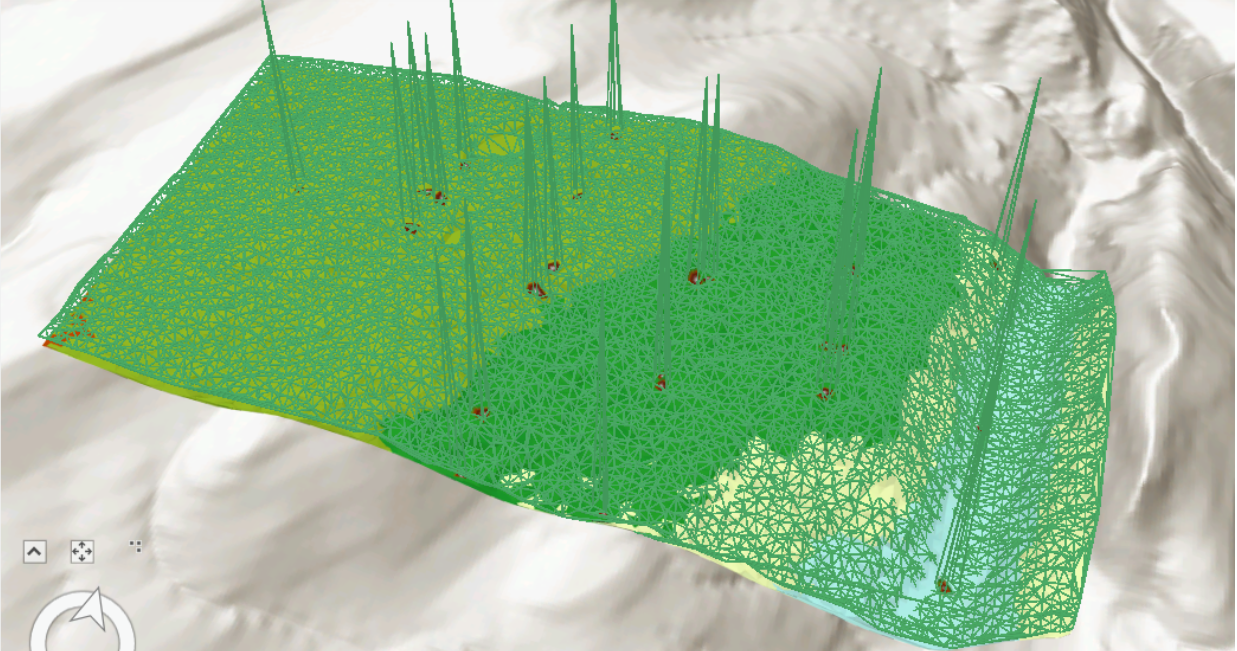

In [19]:
from arcgis.mapping import WebScene
webscene_obj = WebScene(ws_item)
webscene_obj

MapView(hide_mode_switch=True, layout=Layout(height='400px', width='100%'), mode='3D')

The WebScene object displays as:

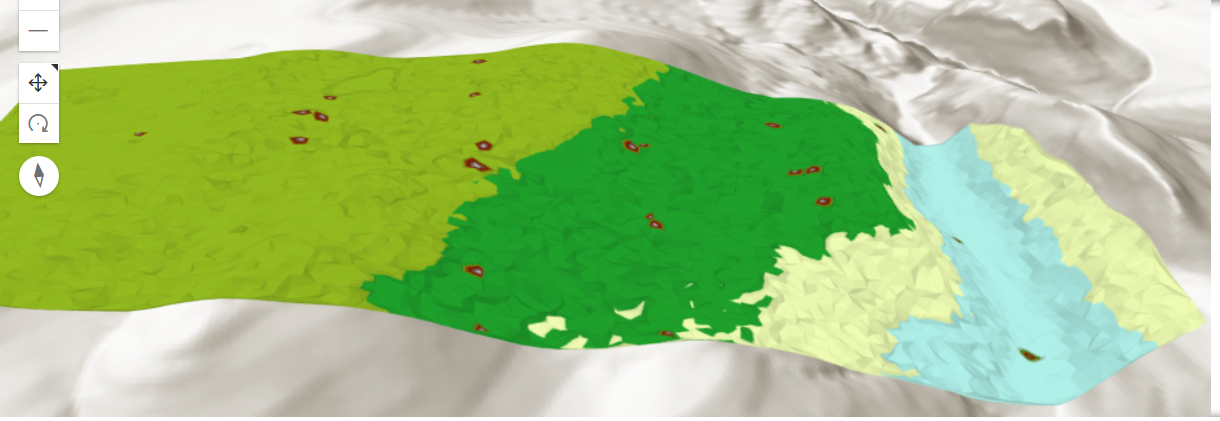

With TIN created, we can then export TIN elements to feature classes, then create a terrain dataset, and add pyramids to the terrain accordingly. A complete workflow is shown below:

In [ ]:
try:    
    # Create the file gdb that will store the feature dataset
    arcpy.management.CreateFileGDB(gdb_location, gdb_name)    
    gdb = '{0}/{1}'.format(gdb_location, gdb_name)
    # Obtain spatial reference from TIN
    SR = arcpy.Describe(out_tin_path).spatialReference
    # Create the feature dataset that will store the terrain
    arcpy.management.CreateFeatureDataset(gdb, fd_name, SR)
    fd = '{0}/{1}'.format(gdb, fdName)
    
    # Export TIN elements to feature classes for terrain
    arcpy.AddMessage("Exporting TIN footprint to define terrain boundary...")
    boundary = "{0}/boundary".format(fd)
    # Execute TinDomain
    arcpy.ddd.TinDomain(out_tin_path, boundary, 'POLYGON')
    arcpy.AddMessage("Exporting TIN breaklines...")
    breaklines = "{0}/breaklines".format(fd)
    # Execute TinLine
    arcpy.ddd.TinLine(out_tin_path, breaklines, "Code")
    arcpy.AddMessage("Exporting TIN nodes...")
    masspoints = "{0}/masspoints".format(fd)
    # Execute TinNode
    arcpy.ddd.TinNode(out_tin_path, masspoints)
    
    arcpy.AddMessage("Creating terrain dataset...")
    terrain = "terrain_from_tin"
    # Execute CreateTerrain
    arcpy.ddd.CreateTerrain(fd, terrain_name, 10, 50000, "", 
                            "WINDOWSIZE", "ZMEAN", "NONE", 1)
    arcpy.AddMessage("Adding terrain pyramid levels...")
    terrain = "{0}/{1}".format(fd, terrainName)
    pyramids = ["20 5000", "25 10000", "35 25000", "50 50000"]
    # Execute AddTerrainPyramidLevel
    arcpy.ddd.AddTerrainPyramidLevel(terrain, "", pyramids)
    
    arcpy.AddMessage("Adding features to terrain...")
    in_features = "{0} Shape softclip 1 0 20 true false boundary_embed <None> "\
             "false; {1} Shape masspoints 1 0 50 true false points_embed "\
             "<None> false; {2} Shape softline 1 0 25 false false lines_embed "\
             "<None> false".format(boundary, masspoints, breaklines)
    # Execute AddFeatureClassToTerrain
    arcpy.ddd.AddFeatureClassToTerrain(terrain, in_features) 
    arcpy.AddMessage("Building terrain...")
    # Execute BuildTerrain
    arcpy.ddd.BuildTerrain(terrain, "NO_UPDATE_EXTENT")
    arcpy.GetMessages()

except arcpy.ExecuteError:  
    print(arcpy.GetMessages())

In [ ]:
print(arcpy.GetMessages())

The `CheckInExtension` function should be used to return the license to the license manager so other applications can use it.

In [ ]:
arcpy.CheckInExtension("3D")

Raster, TIN, Terrain, and LAS datasets are all types of a `functional surface`. 

A functional surface is "a continuous field of values that may vary over an infinite number of points". For example, points in an area on the earth's surface may vary in elevation, proximity to a feature, or concentration of a particular chemical. Any of these values may be represented on the z-axis in a three-dimensional x,y,z coordinate system, so they are often called z-values. 

Surface models allow you to store surface information in a GIS. Because a surface contains an infinite number of points, it is impossible to measure and record the z-value at every point. A surface model approximates a surface by taking a sample of the values at different points on the surface and interpolating the values between these points <a href="#Referenes">[4]</a>.

Now we have briefly talked about constructing TIN and Terrain datasets from LASD, let's change to a different point of view, and explore the usages of Raster functional surface being derived from LASD.


### 2. Create Raster Surfaces

In section 2, we will start with the creation and visualization of three types of elevation models (DTM, DSM and CHM), and then circle back to the display of TIN dataset.

#### 2.1 DTMs and DSMs (LAS Dataset To Raster geoprocessing tool)

There are 3 most common LiDAR-derived data products <a href="#Referenes">[5]</a>:
  - **Digital Terrain Model (or DTM)**: ground elevation.
  - **Digital Surface Model (or DSM)**: top of the surface (imagine draping a sheet over the canopy of a forest).
  - **Canopy Height Model (or CHM)**: the elevation of the Earth’s surface - and it sometimes also called a DEM or digital elevation model.
  
<img src="https://www.earthdatascience.org/images/courses/earth-analytics/lidar-raster-data-r/lidarTree-height.png" width="60%" height="60%" />
<figcaption text-align="center">Fig 2. Digital Surface Model (DSM), Digital Elevation Models (DEM) and the Canopy Height Model (CHM) are the most common raster format lidar derived data products. One way to derive a CHM is to take the difference between the digital surface model (DSM, tops of trees, buildings and other objects) and the Digital Terrain Model (DTM, ground level). The CHM represents the actual height of trees, buildings, etc. with the influence of ground elevation removed. Graphic: Colin Williams, NEON (Source:<a href="#Referenes">[5]</a>)</figcaption>

Next, we will be looking at steps in creating these three products:

##### 2.1.1 Create DEM and DSM

First, `DTM` and `DSM` can both be generated via `LasDatasetToRaster` tool, but with different input criteria:
  - For a `DTM`, use only **returns classified as ground** (under the assumption that the `lasd` is applicable to filter between ground/non ground) in your LAS Dataset. Point cloud data obtained from LiDAR surveys represent elevations of various landscape features. These features are classified into codes, e.g. 1 = Unassigned, 2 = Ground, ... 6 = Building, and 7 = Low Noise. Various digital elevation models can be produced from this data. In order to generate Bare Earth DEM, only the **ground classification code** will be used.
  - For a `DSM`, use only **First returns** in your LAS Dataset, since it is showing the return of those surfaces hit first by the LiDAR pulses. Similarly, besides `classification code`, the `return values` are also one of the filtering criteria. Your LAS Dataset can be filtered to show only **First Returns** before being fed into the `LasDatasetToRaster` tool.

In order for `LasDatasetToRaster` to export elevation raster from ground measurements of LAS files, its `value_field` parameter needs to be set as `ELEVATION` among these three options <a href="#References">[4]</a>:
  - `ELEVATION` — Elevation from the lidar files will be used to create the raster. This is the default.
  - `INTENSITY` — Intensity information from the lidar files will be used to create the raster.
  - `RGB` — RGB values from the lidar points will be used to create 3-band imagery.
  
As for other configurations, we will need to change the `Interpolation method` to `Triangulation`, select `Natural Neighbor` as the Interpolation Method, and leave the default `Point Thinning Type` to `No Thinning`. As for the `sample size` or say the `output cell size`, a fair number of published journals have recommended you use a cell size that is equivalent or so to the nominal point spacing of your LiDAR data.  ESRI suggests using a cell size 2-3 times larger than the nominal point spacing, but from personal experience, using the same as the nominal point spacing works well.
  - Here, you might want to consider the trade-off between accuracy and computation time. The smaller the cell size, the longer it takes for the process to finish.

The `DTM` represents the ground - and thus DOES NOT INCLUDE trees, buildings and other objects. To start with, first filter the LAS Dataset to show only `ground` points, then perform the cell below:

In [ ]:
root_folder = r"<Root Folder>\NEON_lidar-point-cloud-line"
dataset_name = "2017_unclassified_collection"

In [3]:
import os
absolute_raster_path1 = os.path.join(root_folder, relative_gdb_path， "two_las_raster_dtm")
# converting LAS Dataset to DEM
arcpy.conversion.LasDatasetToRaster(in_las_dataset = "2017_Survey_Collection1.lasd", 
                                    out_raster = absolute_raster_path1,
                                    value_field = "ELEVATION", 
                                    interpolation_type = None, 
                                    data_type = "FLOAT", 
                                    sampling_type = "CELLSIZE", 
                                    sampling_value = 10, 
                                    z_factor = 1)

<Result '<Root Folder>\NEON_lidar-point-cloud-line\2017_unclassified_collection\2017_survey_collection.gdb\two_las_raster_dtm'>


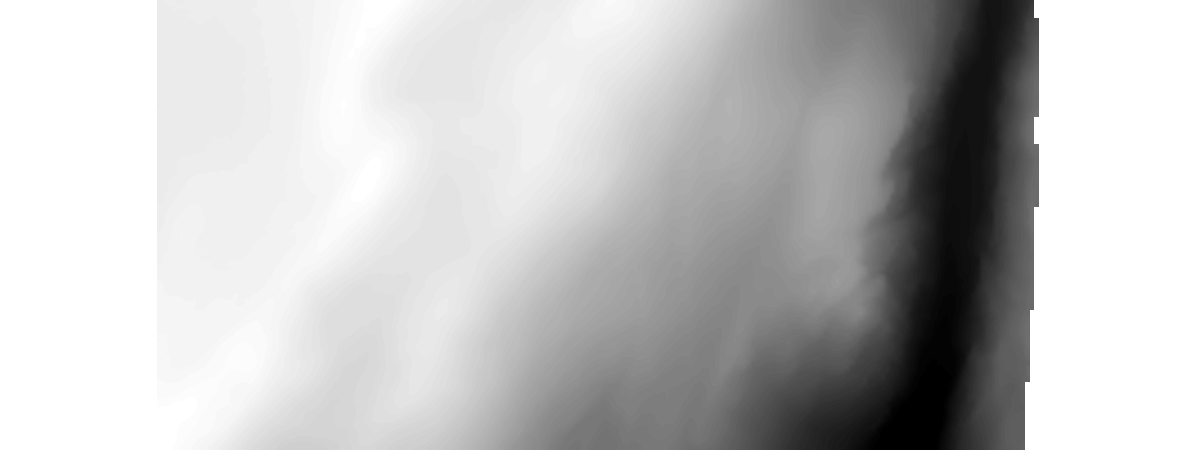

In [2]:
from arcgis.raster import ImageryLayer
dtm_img_lyr = ImageryLayer(url="https://your.server.domain.com/server/rest/services/imagery_layer_two_las_raster_dtm/ImageServer",
                           gis = gis)
dtm_img_lyr

Here, we will use the `remap` function to normalize the input datasets to a common scale of 1 - 9. Locations assigned the value of 1 are considered the least suitable according to our criteria (e.g. the steepest slopes are the least accessible for travel), while locations assigned the value of 9 are considered the most suitable according to our criteria (e.g. areas that are least modified by human activity are more "natural").

<img src="http://esri.github.io/arcgis-python-api/notebooks/nbimages/04_WeightedOverlay_clrmp.png" />

In [19]:
# Create a colormap to display the analysis results with 9 colors ranging from red to yellow to green.
clrmap=  [[1, 230, 0, 0], [2, 242, 85, 0], [3, 250, 142, 0], [4, 255, 195, 0], [5, 255, 255, 0], [6, 197, 219, 0],  
          [7, 139, 181, 0], [8, 86, 148, 0], [9, 38, 115, 0]]

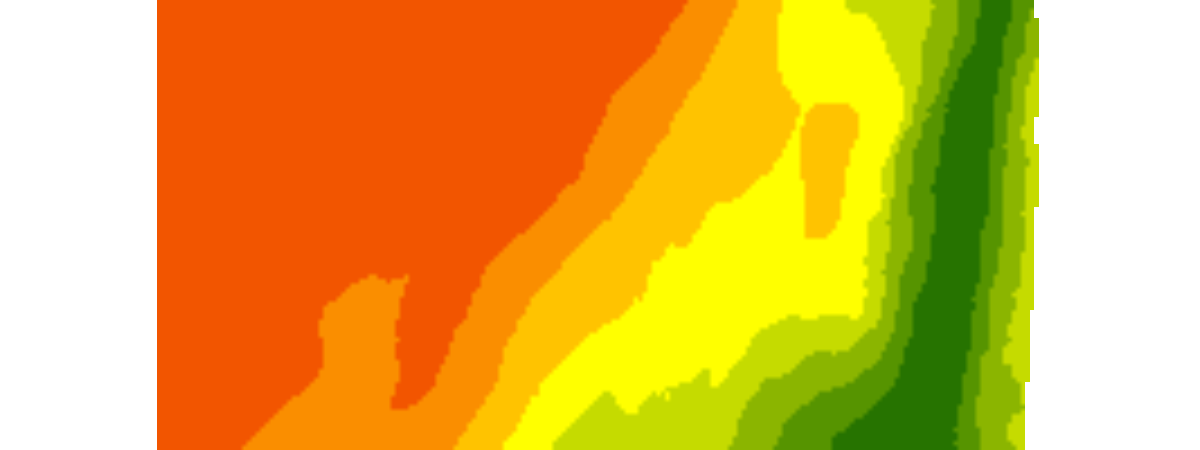

In [23]:
# Import the raster functions from the API
from arcgis.raster.functions import remap, colormap

# Reclassify (normalize) the elevation data
dtm_img_lyr_normalized = remap(dtm_img_lyr,
                               input_ranges=[2325,2375, 2375,2425, 2425,2475, 2475,2525, 2525,2575, 
                                             2575,2625, 2625,2675, 2675,2725, 2725,2775],
                               output_values=[9,8,7,6,5,4,3,2,1], astype='U8')

# Display color-mapped image of the reclassified elevation data
colormap(dtm_img_lyr_normalized, colormap=clrmap)

Now, we have obtained the DTM output (min=2325.17, max=2724.78, unit=meters), let's clear the previous filtering criteria, and then set up the new filter with `First returns` and perform `LasDatasetToRaster` once again.

In [2]:
absolute_raster_path2 = os.path.join(root_folder, relative_gdb_path， "two_las_raster_dsm")
arcpy.conversion.LasDatasetToRaster(in_las_dataset = "2017_Survey_Collection1.lasd", 
                                    out_raster = absolute_raster_path2,
                                    value_field = "ELEVATION", 
                                    interpolation_type = None, 
                                    data_type = "FLOAT", 
                                    sampling_type = "CELLSIZE", 
                                    sampling_value = 10, 
                                    z_factor = 1)

<Result '<Root Folder>\NEON_lidar-point-cloud-line\2017_unclassified_collection\2017_survey_collection.gdb\two_las_raster_dsm'>


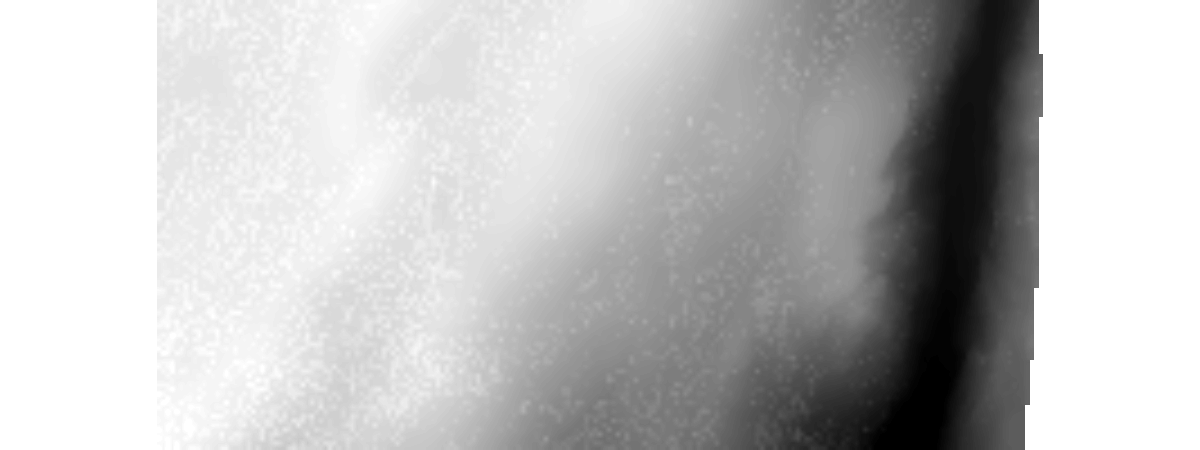

In [9]:
dsm_img_lyr = ImageryLayer(url="https://your.server.domain.com/server/rest/services/imagery_layer_two_las_raster_dsm/ImageServer",
                           gis = gis)
dsm_img_lyr

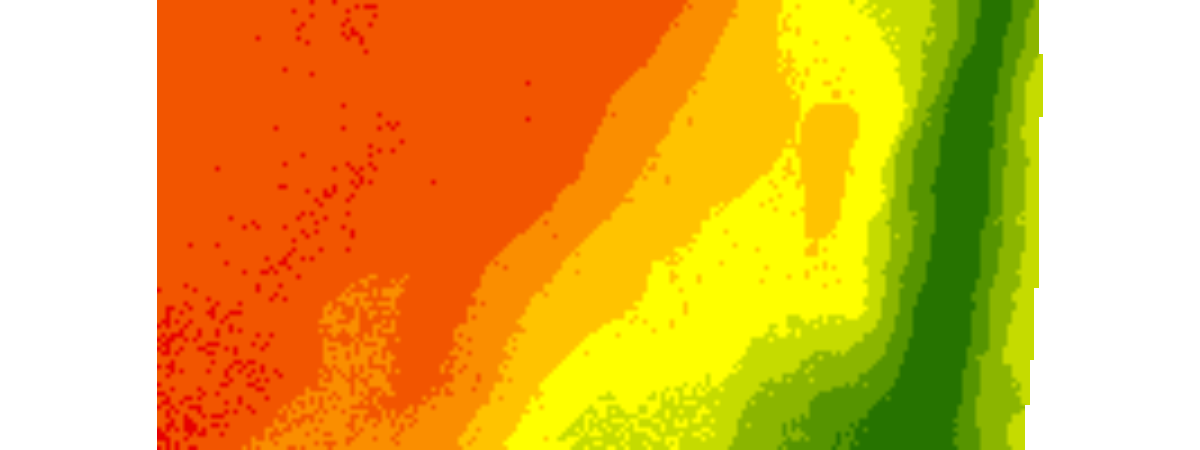

In [24]:
# Reclassify (normalize) the elevation data
dsm_img_lyr_normalized = remap(dsm_img_lyr,
                               input_ranges=[2325,2375, 2375,2425, 2425,2475, 2475,2525, 2525,2575, 
                                             2575,2625, 2625,2675, 2675,2725, 2725,2775],
                               output_values=[9,8,7,6,5,4,3,2,1], astype='U8')

# Display color-mapped image of the reclassified elevation data
colormap(dsm_img_lyr_normalized, colormap=clrmap)

And now we have got the DSM output as well (min=2325.17, max=2751.84, unit=meters). The DSM represents the top of the earth’s surface. Thus, it INCLUDES TREES, BUILDINGS and other objects that sit on the earth. Compared with the previous DTM colormap, we can see the DSM output has more dots and is less smooth, and these dots are highly likely representations of trees, buildings, etc.

##### 2.1.2 Derive CHM

The canopy height model (CHM) represents the HEIGHT of the trees. This is not an elevation value, rather it’s the height or distance between the ground and the top of the trees (or buildings or whatever object that the LiDAR system detected and recorded).

The main task of deriving CHM is to calculate difference between two rasters, i.e. to subtract the DTM from the DSM.
```
CHM = DSM - DTM
```

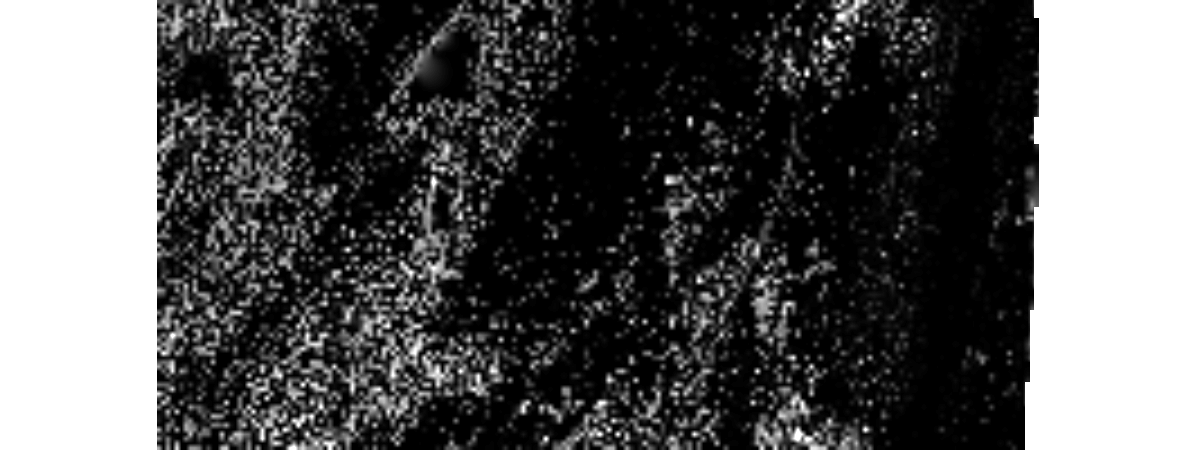

In [31]:
chm_img_lyr = dsm_img_lyr - dtm_img_lyr
chm_img_lyr

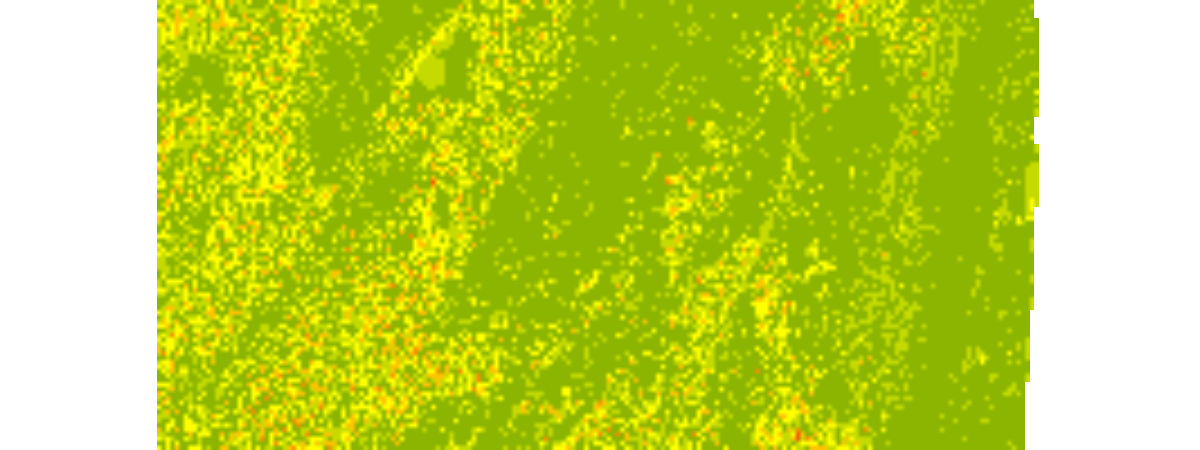

In [41]:
# Reclassify (normalize) the elevation data
chm_img_lyr_normalized = remap(chm_img_lyr,
                               input_ranges=[-32,-21, -21,-10, -10,1, 1,12, 12,23, 23,34, 34,45, 45,56, 
                                             56,67],
                               output_values=[9,8,7,6,5,4,3,2,1], astype='U8')

# Display color-mapped image of the reclassified elevation data
colormap(chm_img_lyr_normalized, colormap=clrmap)

#### 2.2 Derived products of DTM

With a terrain land form represented by a digital elevation model (a.k.a. DTM), we can then quantify and visualize with some surface tools in ArcGIS API for Python, or the arcpy tools. We can gain information by producing a new dataset that identifies a specific pattern within an original dataset, and derive patterns that were not readily apparent in the original surface, such as **angle of slope, steepest downslope direction (Aspect), or shaded relief (Hillshade)**.

In [88]:
# Import the raster functions from the API
from arcgis.raster.functions import aspect, stretch, slope, curvature, hillshade

##### 2.2.1 Aspect

The API method `aspect` derives aspect from a raster surface. The aspect identifies the downslope direction of the maximum rate of change in value from each cell to its neighbors, and can be thought of as the slope direction. The values of the output raster will be the compass direction of the aspect.

`Aspect` is expressed in positive degrees from 0 to 359.9, measured clockwise from north.

Cells in the input raster that are flat — with zero slope — are assigned an aspect of -1.

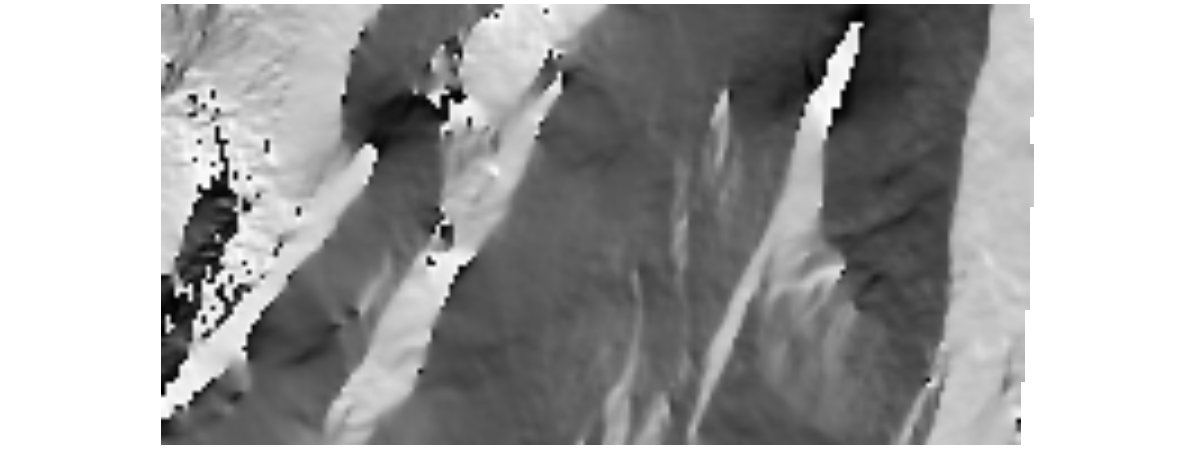

In [54]:
# Derive an aspect layer from the DTM layer using the aspect function
aspect_lyr = aspect(dtm_img_lyr)

# Use the stretch function to enhance the display of the aspect layer.
aspect_lyr_stretched = stretch(raster=aspect_lyr, stretch_type='StdDev', dra='true', astype="U8")
aspect_lyr_stretched

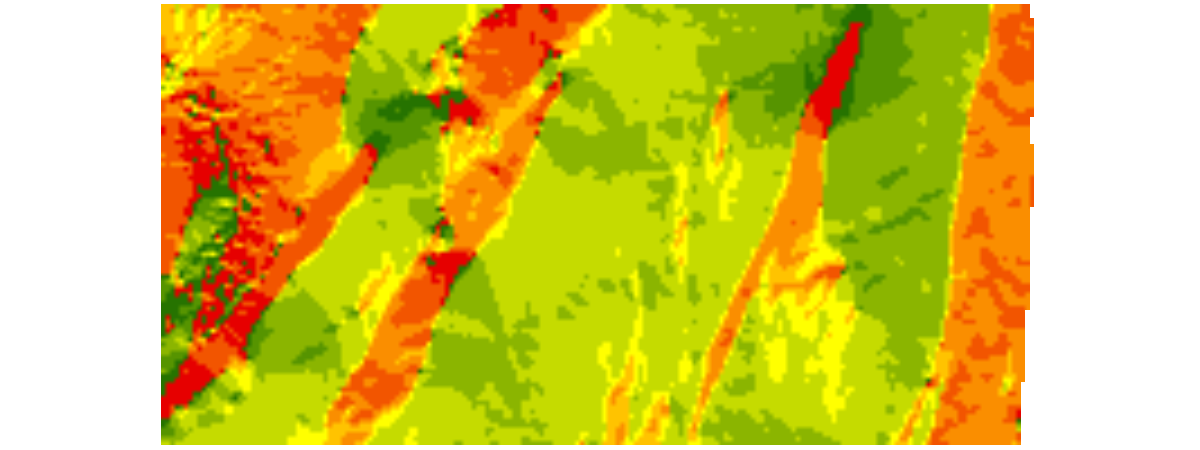

In [77]:
# Reclassify (normalize) the elevation data
aspect_lyr_normalized = remap( aspect_lyr,
                               input_ranges=[0,40, 40,80, 80,120, 120,160, 160,200,
                                            200,240, 240,280, 280,320, 320,360],
                               output_values=[9,8,7,6,5,4,3,2,1], astype='U8')

# Display color-mapped image of the reclassified elevation data
colormap(aspect_lyr_normalized, colormap=clrmap)

##### 2.2.2 Slope

`Slope` is the rate of maximum change in z-value from each cell, from which we can see how the terrain rises up or declines. The use of a z-factor is essential for correct slope calculations when the surface z units are expressed in units different from the ground x,y units.

The API method <a href="https://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/slope.htm">`slope`</a> can identify the slope (gradient, or rate of maximum change in z-value) from each cell of a raster surface. The range of values in the output depends on the type of measurement units.
  - For degrees, the range of slope values is 0 to 90.
  - For percent rise, the range is 0 to essentially infinity. A flat surface is 0 percent, a 45 degree surface is 100 percent, and as the surface becomes more vertical, the percent rise becomes increasingly larger. See how Slope works for a more detailed explanation of the range of output values with this <a href="https://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/slope.htm">option</a>.

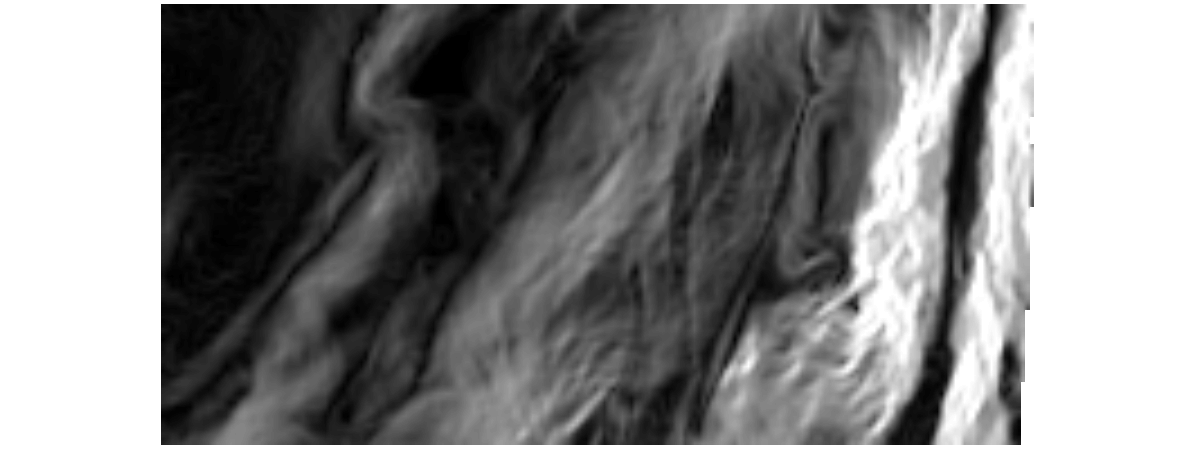

In [14]:
# Derive a slope layer from the DEM layer using the slope function
slope_lyr = slope(dtm_img_lyr, slope_type='DEGREE', z_factor=1)

# Use the stretch function to enhance the display of the slope layer.
stretch(raster=slope_lyr, stretch_type='StdDev', dra='true')

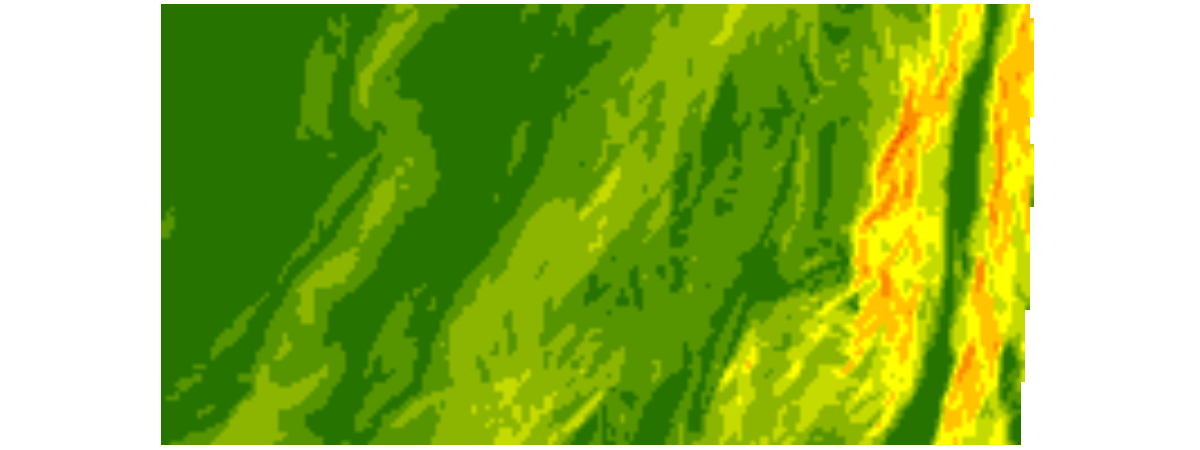

In [76]:
# Reclassify (normalize) the elevation data
slope_lyr_normalized = remap( slope_lyr,
                               input_ranges=[0,10, 10,20, 20,30, 30,40, 40,50, 50,60, 60,70, 70,80, 80,90],
                               output_values=[9,8,7,6,5,4,3,2,1], astype='U8')

# Display color-mapped image of the reclassified elevation data
colormap(slope_lyr_normalized, colormap=clrmap)

Green is little to no slope, yellow is moderate slope, and red is steepest. Note the high amounts of yellow and red sprinkled throughout the surface.

##### 2.2.3 Curvature

The `Curvature` <a href="https://developers.arcgis.com/python/api-reference/arcgis.raster.functions.html#curvature">function</a> displays the shape or curvature of the slope. A part of a surface can be concave or convex; you can tell that by looking at the curvature value. The curvature is calculated by computing the second derivative of the surface. 
The curvature type accentuates different aspects of the slope. There are three curvature options:

  - `Standard`—Combines both the Profile and Planform curvatures.
  - `Profile`—Is parallel to the slope and indicates the direction of maximum slope. It affects the acceleration and deceleration of flow across the surface.
  - `Planform`—Is perpendicular to the direction of the maximum slope. It affects the convergence and divergence of flow across a surface.
  
The units of the curvature output raster are one hundredth (1/100) of a z-unit. The reasonably expected values for a curvature raster for a hilly area (moderate relief) can vary from -0.5 to 0.5; while for steep, rugged mountains (extreme relief), the values can vary between -4 and 4. It is possible to exceed these ranges for certain raster surfaces.

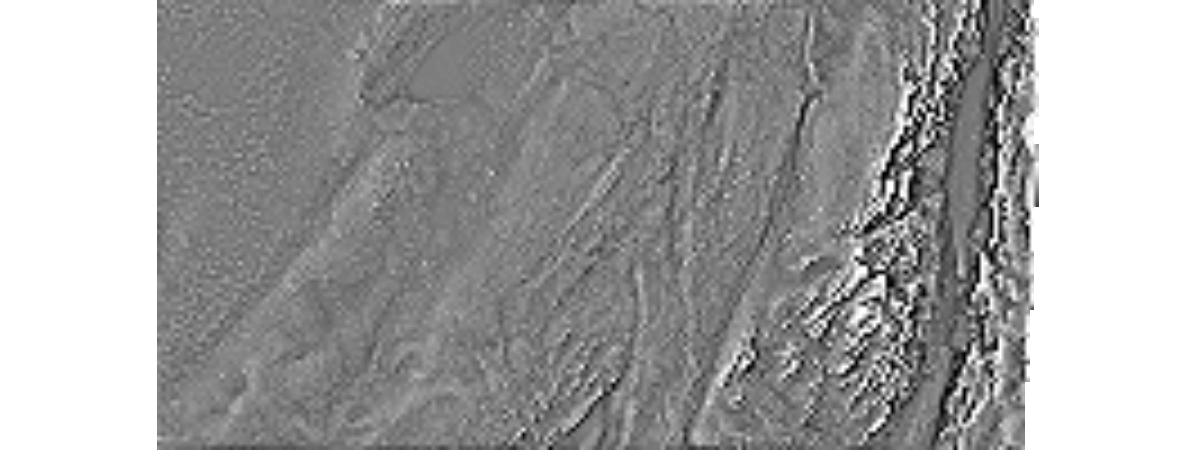

In [79]:
# Derive a curve layer from the DEM layer using the curvature function
curve_lyr = curvature(dtm_img_lyr)

# Use the stretch function to enhance the display of the curve layer.
stretch(raster=curve_lyr, stretch_type='StdDev', dra='true')

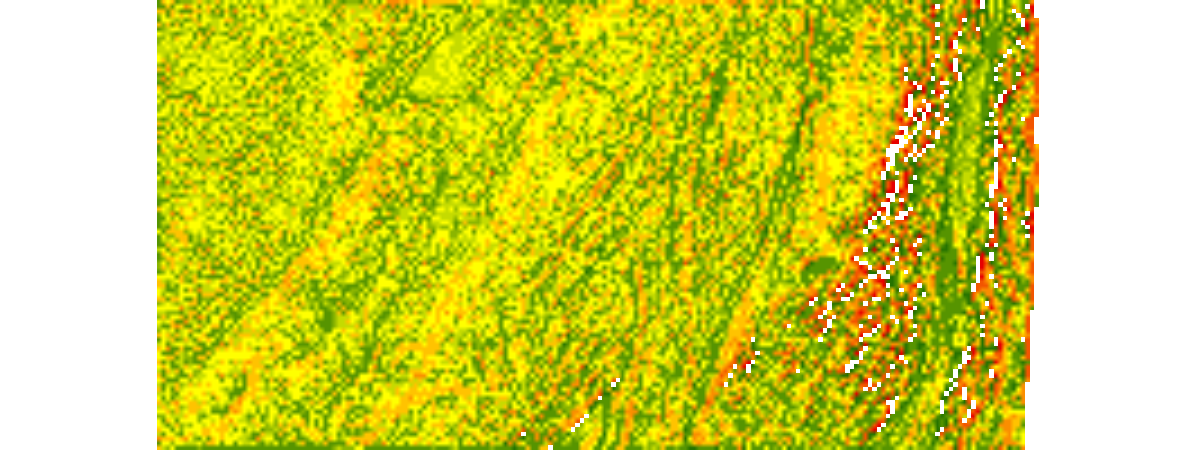

In [87]:
# Reclassify (normalize) the elevation data
curve_lyr_normalized = remap(  curve_lyr,
                               input_ranges=[-10,-5, -5,-1, -1,-0.5, -0.5,0, 0,1, 1,3, 3,7, 7,15,
                                             15,31],
                               output_values=[9,8,7,6,5,4,3,2,1], astype='U8')

# Display color-mapped image of the reclassified elevation data
colormap(curve_lyr_normalized, colormap=clrmap)

In the following diagram, the columns show the `planform` curves, and the rows show the `profile` curve. The **planform** columns are positive, negative, and 0—going from left to right. The **profiles** curves are negative, positive, and 0, going from top to bottom.

<img src="https://desktop.arcgis.com/en/arcmap/latest/manage-data/raster-and-images/GUID-E97C164E-23D8-4D2F-AB06-49EE37912E26-web.png" />

##### 2.2.4 Hillshade

A `hillshade` is a grayscale 3D model of the surface taking the sun’s relative position into account to shade the image. The API function `hillshade` creates a shaded relief from a surface raster by considering the illumination source angle and shadows. For more information, see <a href=’http://desktop.arcgis.com/en/arcmap/latest/manage-data/raster-and-images/hillshade-function.htm’>hillshade function</a> and <a href=”http://desktop.arcgis.com/en/arcmap/latest/tools/spatial-analyst-toolbox/how-hillshade-works.htm”>How hillshade works.</a>
  - The illumination source is considered to be at infinity.
  - The hillshade raster has an integer value range of 0 to 255.

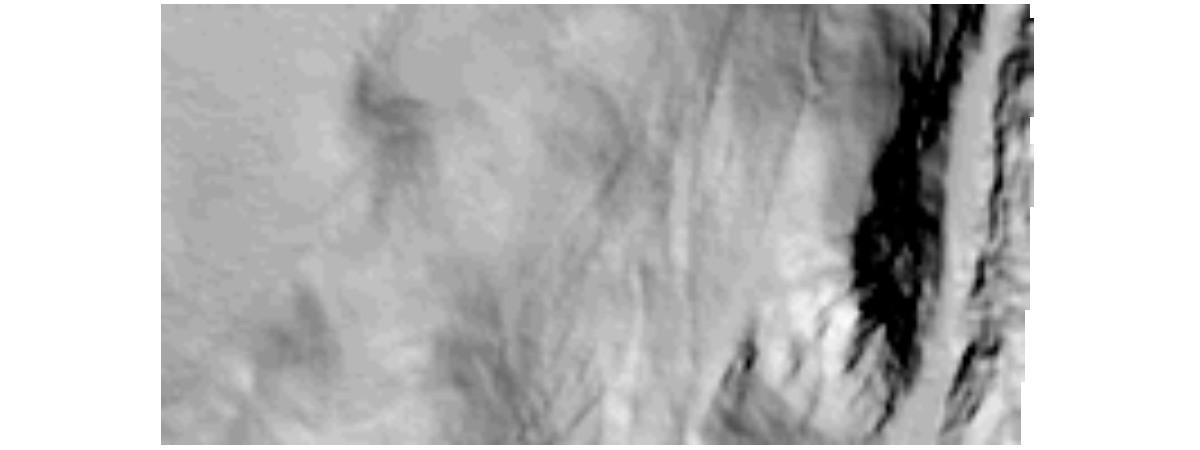

In [89]:
# Derive a hillshade layer from the DTM layer using the hillshade function
hillshade_lyr = hillshade(dtm_img_lyr)

# Use the stretch function to enhance the display of the hillshade layer.
stretch(raster=hillshade_lyr, stretch_type='StdDev', dra='true')

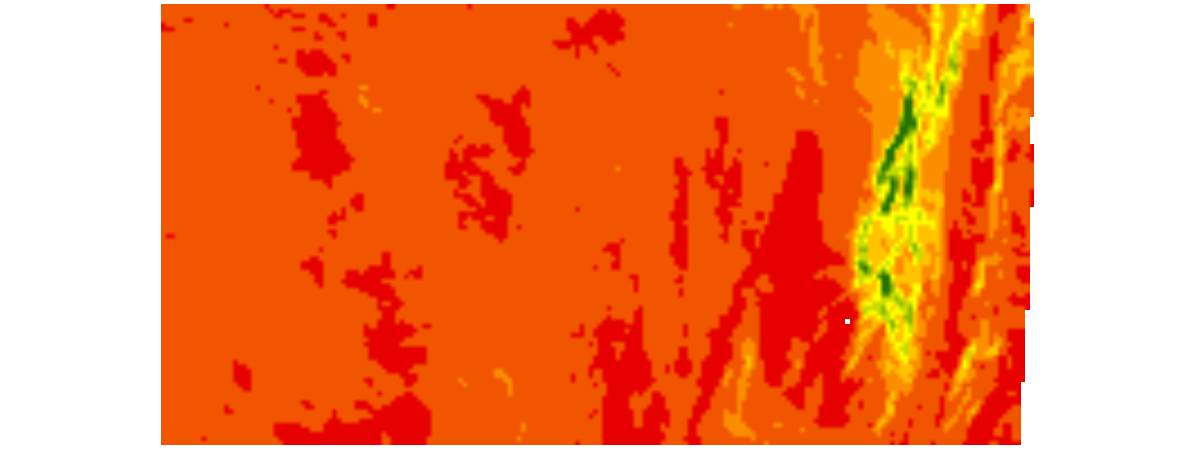

In [100]:
# Reclassify (normalize) the elevation data
hillshade_lyr_normalized = remap(  hillshade_lyr,
                                   input_ranges=[105,195, 195,203, 203,210, 
                                                 210,218, 218,225, 
                                                 225,233, 233,240, 
                                                 240,248, 248,255],
                                   output_values=[9,8,7,6,5,4,3,2,1], astype='U8')

# Display color-mapped image of the reclassified elevation data
colormap(hillshade_lyr_normalized, colormap=clrmap)

##### 2.2.5 Contours

In [ ]:
from arcpy.sa import Contour
import pandas as pd
from arcgis.features import GeoAccessor, GeoSeriesAccessor

In [3]:
inRaster = "elevation"
contourInterval = 200
baseContour = 0
outContours = r"<Vector DataStore>\two_las_raster_contour.shp"
Contour(inRaster, outContours, contourInterval, baseContour)

In [4]:
sdf = pd.DataFrame.spatial.from_featureclass(outContours)
sdf.tail()

C:\ArcGIS\bin\Python\envs\arcgispro-py3\lib\site-packages\IPython\lib\pretty.py:402: FutureWarning: 'ExtensionArray._formatting_values' is deprecated. Specify 'ExtensionArray._formatter' instead.
  return _repr_pprint(obj, self, cycle)
C:\ArcGIS\bin\Python\envs\arcgispro-py3\lib\site-packages\pandas\io\formats\html.py:606: FutureWarning: 'ExtensionArray._formatting_values' is deprecated. Specify 'ExtensionArray._formatter' instead.
  super().render()


FID  Id  Contour                                              SHAPE
0    0   1   2600.0  {"paths": [[[324340.4638475341, 4103995], [324...
1    1   2   2400.0  {"paths": [[[324797.387719589, 4103005], [3247...
2    2   3   2400.0  {"paths": [[[324810.5676074955, 4103995], [324...


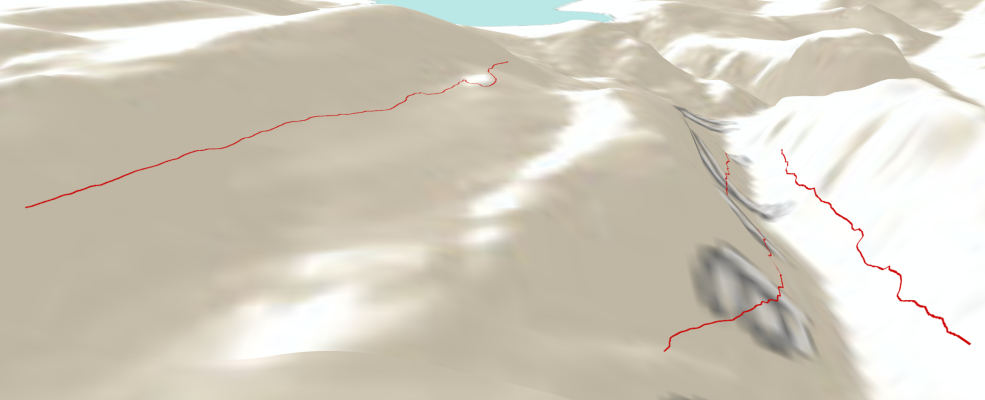

In [17]:
m1 = GIS().map('California, USA', zoomlevel=4, mode="3D")
m1.basemap = 'terrain'
m1

In [15]:
sdf.spatial.plot(map_widget= m1)

True

## References

[1] https://desktop.arcgis.com/en/arcmap/10.3/manage-data/las-dataset/advantages-of-using-lidar-in-gis.htm

[2] https://desktop.arcgis.com/en/arcmap/10.3/manage-data/las-dataset/incorporating-breaklines-with-lidar.htm

[3] https://desktop.arcgis.com/en/arcmap/10.3/tools/conversion-toolbox/las-dataset-to-raster.htm

[4] https://desktop.arcgis.com/en/arcmap/10.3/guide-books/extensions/3d-analyst/fundamentals-of-3d-surfaces.htm

[5] https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/lidar-chm-dem-dsm/

[6] https://desktop.arcgis.com/en/arcmap/10.3/manage-data/tin/fundamentals-of-creating-tins.htm

<a href="#Table-of-Contents">Back to the Top</a>